<a href="https://colab.research.google.com/github/bugeki/Forecasting_bus_demand_LSTM/blob/main/forecasting_bus_demand_with_simple_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forecasting bus demand in Banana Republic municipalities.**

The central urban planning commitee of Banana Republic asked you to help them with the forecast of bus demands of municipalities. And they provide a nice dataset to support you (https://pi.works/3w8IJbV). The dataset includes two measurements for an hour for the number of used buses in each municipality, each measurement is timestamped. The dataset format is as follows (comma separated values): MUNICIPALITY_ID, TIMESTAMP, USAGE, TOTAL_CAPACITY where municipality_id is an anonymization to disguise the actual names, timestamp represents the exact time of the measurement, usage is the number of buses in use at the time of measurement and total_capacity represents the total number of buses in the municipality. There are 10 municipalities (ids from 0 to 9), and two measurements for an hour. The committee asks you to forecast the hourly bus usages for next week for each municipality. Hence you can aggregate the two measurements for an hour by taking the max value (sum would not be a nice idea for the obvious reasons) for each hour, and you should model this data with a time series model of your selection. (It would be a nice idea to implement a very simple baseline model first, and then try to improve the accuracy by introducing more complex methods eventually. The bare minimum requirement of the task is one simple baseline and one complex method.) The committee says that they will use the last two weeks (starting from 2017-08-05 to 2017-08-19) as assessment (test) data, hence your code should report the error (in the criterion you chose for the task) for the last two weeks. You may use true values for the prediction of the last week of test data, then combine the error of the first and last week of the test separately. Keep in mind that the dataset has missing data, hence a suitable missing data interpolation would be useful.

In [1]:
  import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [2]:
!pip install colorama
import colorama
from colorama import Fore, Style  # makes strings colored
!pip3 install termcolor
from termcolor import colored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Recognizing and Understanding Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/RNN/municipality_bus_utilization.csv')

In [5]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [6]:
def missing(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

def missing_values(df):
    return missing(df)[missing(df)['Missing_Number']>0]
    
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n',
          f"There is ", df.shape[0], " observation and ", df.shape[1], " columns in the dataset.", '\n',
          colored('-'*79, 'magenta', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'magenta', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'magenta', attrs=['bold']), sep='')

def first_looking_col(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False)) 

In [7]:
first_looking(df)

Shape:(13070, 4)
There is 13070 observation and 4 columns in the dataset.
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB
None
-------------------------------------------------------------------------------
Number of Uniques:
timestamp          1309
municipality_id      10
usage              2346
total_capacity       10
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------

In [8]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [9]:
first_looking_col("usage")

column name    :  usage
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2346
411     69
354     62
399     31
410     28
623     27
        ..
2830     1
2783     1
2664     1
2463     1
1680     1
Name: usage, Length: 2346, dtype: int64


In [10]:
df.duplicated().value_counts()

False    13070
dtype: int64

In [11]:
# convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Hourly max value

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        13070 non-null  datetime64[ns]
 1   municipality_id  13070 non-null  int64         
 2   usage            13070 non-null  int64         
 3   total_capacity   13070 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 408.6 KB


In [14]:
#dfm = df.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
dfm = df.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()

In [15]:
dfm

timestamp
2017-06-04 07:00:00   1090.000
2017-06-04 08:00:00   2016.000
2017-06-04 09:00:00   2811.000
2017-06-04 10:00:00   3178.000
2017-06-04 11:00:00   3257.000
                        ...   
2017-08-19 12:00:00   3157.000
2017-08-19 13:00:00   3194.000
2017-08-19 14:00:00   3183.000
2017-08-19 15:00:00   3111.000
2017-08-19 16:00:00   2779.000
Freq: H, Name: usage, Length: 1834, dtype: float64

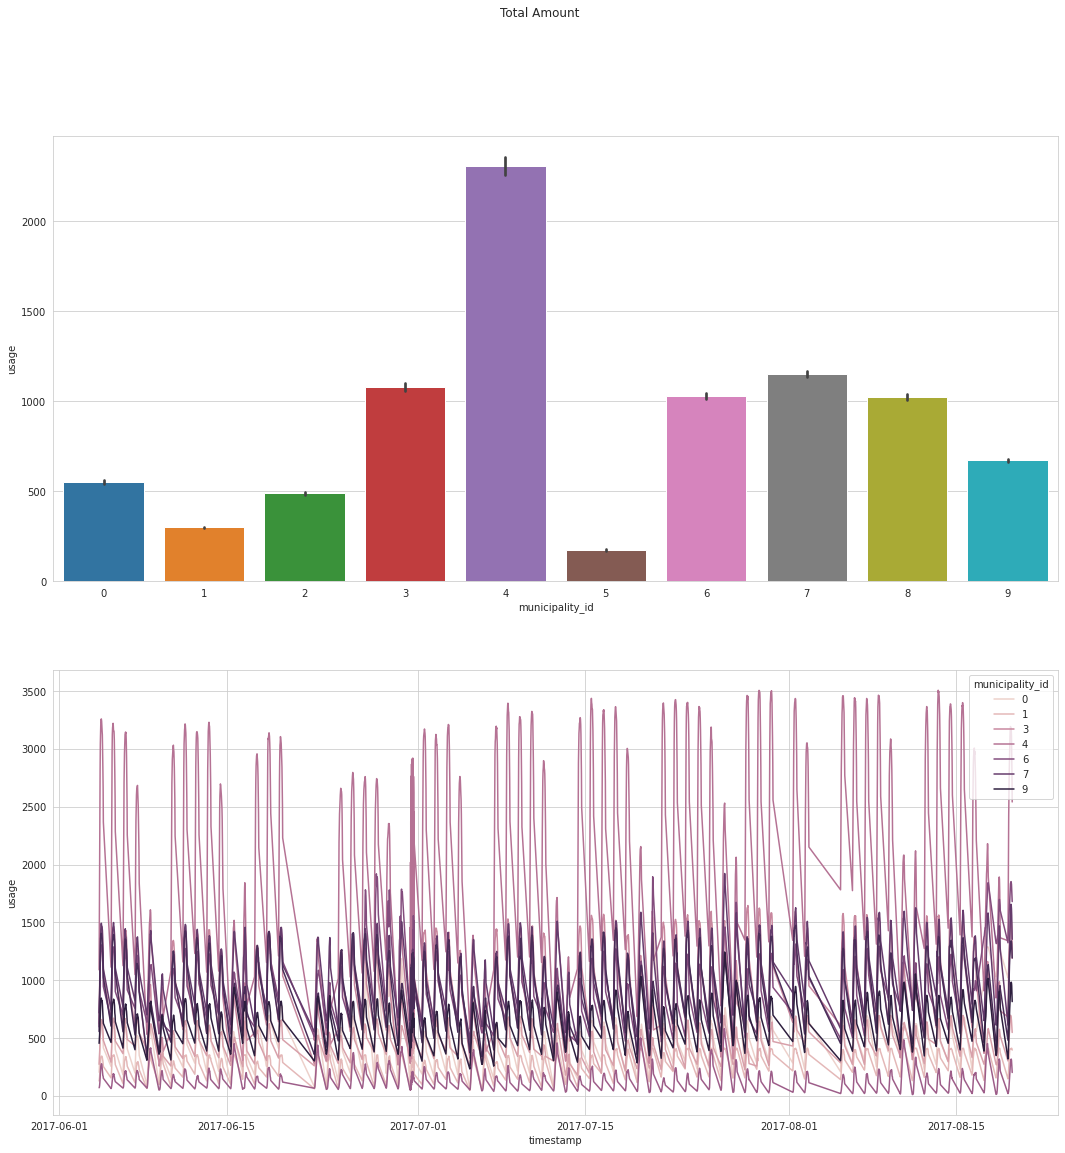

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18,18))
s = sns.barplot(ax = ax1, x="municipality_id", y="usage", data=df)
s = sns.lineplot(ax = ax2, x='timestamp', y="usage", data=df, color="red", hue='municipality_id')
plt.suptitle("Total Amount")
plt.show();

In [22]:
df.tail()

,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


### Separating municipalities

In [23]:
muni_id=list(df['municipality_id'].unique())

In [24]:
muni_id.sort()

In [25]:
muni_id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [37]:
d = {i: df[df['municipality_id'] == i] for i in muni_id}

In [38]:
%%script echo skipping
df1=d[1]
df2=d[2]
df3=d[3]
df4=d[4]
df5=d[5]
df6=d[6]
df7=d[7]
df8=d[8]
df9=d[9]


skipping


###df0

In [39]:
df0=d[0]#.reset_index(drop=True)

In [40]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 13062
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        1307 non-null   datetime64[ns]
 1   municipality_id  1307 non-null   int64         
 2   usage            1307 non-null   int64         
 3   total_capacity   1307 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 51.1 KB


In [41]:
#df0.groupby([pd.Grouper(key='timestamp', freq='H'),'timestamp', 'municipality_id'], as_index=False)['usage'].transform(max)

In [42]:
#df0.set_index('date',inplace=True)

In [43]:
#df0 = df0.set_index('timestamp')
#df0 = df0.fillna(method='ffill')
#print(df0)

In [44]:
#all_days = pd.date_range(df0.index.min(), df0.index.max(), freq='D')

In [45]:
#all_days

In [46]:
df0m = df0.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()


In [47]:
df0m.head(30)

timestamp
2017-06-04 07:00:00   204.000
2017-06-04 08:00:00   332.000
2017-06-04 09:00:00   485.000
2017-06-04 10:00:00   583.000
2017-06-04 11:00:00   614.000
2017-06-04 12:00:00   613.000
2017-06-04 13:00:00   605.000
2017-06-04 14:00:00   585.000
2017-06-04 15:00:00   520.000
2017-06-04 16:00:00   470.000
2017-06-04 17:00:00       NaN
2017-06-04 18:00:00       NaN
2017-06-04 19:00:00       NaN
2017-06-04 20:00:00       NaN
2017-06-04 21:00:00       NaN
2017-06-04 22:00:00       NaN
2017-06-04 23:00:00       NaN
2017-06-05 00:00:00       NaN
2017-06-05 01:00:00       NaN
2017-06-05 02:00:00       NaN
2017-06-05 03:00:00       NaN
2017-06-05 04:00:00       NaN
2017-06-05 05:00:00       NaN
2017-06-05 06:00:00       NaN
2017-06-05 07:00:00   255.000
2017-06-05 08:00:00   335.000
2017-06-05 09:00:00   487.000
2017-06-05 10:00:00   595.000
2017-06-05 11:00:00   612.000
2017-06-05 12:00:00   595.000
Freq: H, Name: usage, dtype: float64

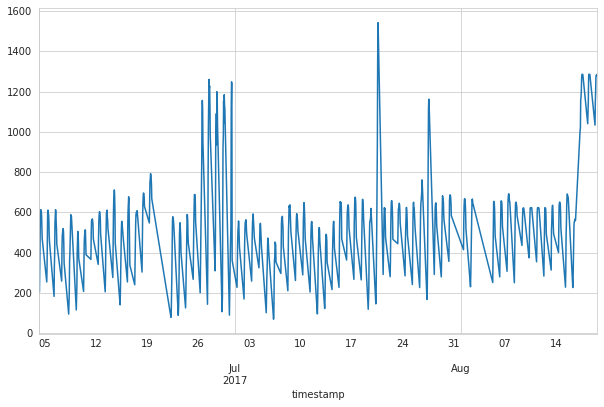

In [48]:
df0m.interpolate().plot()

In [49]:
df0=df0m.interpolate() 

In [50]:
df0.columns='usage' 

In [51]:
df0=pd.DataFrame(df0) 

In [52]:
df0

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


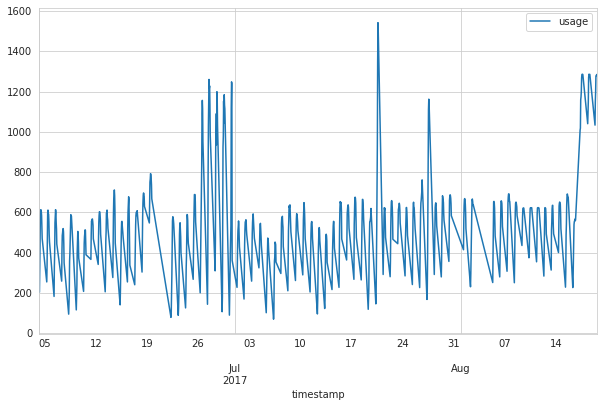

In [53]:
df0.plot()

# Preprocessing of Data

## Train Test Split

In [121]:
df0.loc['2017-08-05 00:00:00':] 

,usage
timestamp,
2017-08-05 00:00:00,300.250
2017-08-05 01:00:00,294.219
2017-08-05 02:00:00,288.188
2017-08-05 03:00:00,282.156
2017-08-05 04:00:00,276.125
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [122]:
df0.shape

(1834, 1)

In [123]:
df0.loc['2017-08-05 08:29:08':]   # 2 weeks test data

,usage
timestamp,
2017-08-05 09:00:00,393.000
2017-08-05 10:00:00,517.000
2017-08-05 11:00:00,653.000
2017-08-05 12:00:00,655.000
2017-08-05 13:00:00,649.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [124]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1834 entries, 2017-06-04 07:00:00 to 2017-08-19 16:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usage   1834 non-null   float64
dtypes: float64(1)
memory usage: 93.2 KB


In [125]:
train, test = df0.loc[:'2017-08-04 23:00:00'], df0.loc['2017-08-05 00:00:00':]
print(len(train), len(test))

1481 353


In [126]:
train

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-04 19:00:00,330.406
2017-08-04 20:00:00,324.375
2017-08-04 21:00:00,318.344


In [127]:
test

,usage
timestamp,
2017-08-05 00:00:00,300.250
2017-08-05 01:00:00,294.219
2017-08-05 02:00:00,288.188
2017-08-05 03:00:00,282.156
2017-08-05 04:00:00,276.125
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


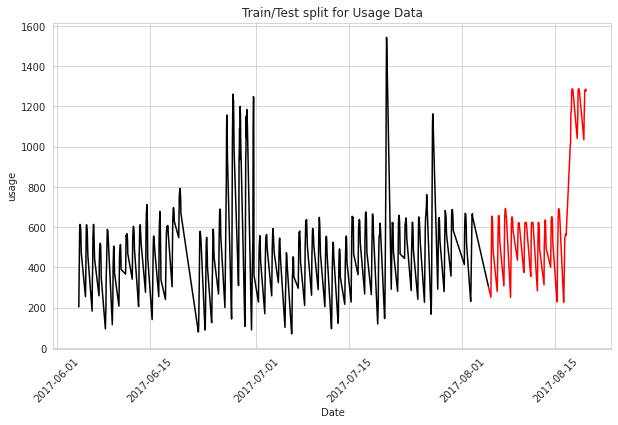

In [128]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('usage')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Usage Data")
plt.show()

## Scaling

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler()

In [131]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [132]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [133]:
#help(TimeseriesGenerator)

In [134]:
# define generator
length = 24 # Length of the output sequences (in number of timesteps)
batch_size = 50 # Number of timeseries samples in each batch
stride = 1 # Period between successive output sequences
generator = TimeseriesGenerator(data = train_scaled,
                                targets = train_scaled, # train sequence and target sequence are in same column
                                length = length,
                                batch_size = batch_size,
                                stride = stride)

In [135]:
len(train_scaled)

1481

In [136]:
len(generator) 

30

In [137]:
generator

In [138]:
train_scaled

array([[0.09097081],
       [0.1778683 ],
       [0.28173795],
       ...,
       [0.16859725],
       [0.16450272],
       [0.16040818]])

In [139]:
generator[0]

(array([[[0.09097081],
         [0.1778683 ],
         [0.28173795],
         ...,
         [0.15478615],
         [0.14505544],
         [0.13532473]],
 
        [[0.1778683 ],
         [0.28173795],
         [0.34826884],
         ...,
         [0.14505544],
         [0.13532473],
         [0.12559403]],
 
        [[0.28173795],
         [0.34826884],
         [0.36931432],
         ...,
         [0.13532473],
         [0.12559403],
         [0.17990496]],
 
        ...,
 
        [[0.08897941],
         [0.07671419],
         [0.17854718],
         ...,
         [0.16734555],
         [0.15953836],
         [0.15173116]],
 
        [[0.07671419],
         [0.17854718],
         [0.22267481],
         ...,
         [0.15953836],
         [0.15173116],
         [0.14392396]],
 
        [[0.17854718],
         [0.22267481],
         [0.32518669],
         ...,
         [0.15173116],
         [0.14392396],
         [0.13611677]]]), array([[0.12559403],
        [0.17990496],
        [0.2

In [140]:

X, y = generator[0]

In [141]:
print(f'Given the Array: \n{X}')
print(f'Predict this y: \n{y}')

Given the Array: 
[[[0.09097081]
  [0.1778683 ]
  [0.28173795]
  ...
  [0.15478615]
  [0.14505544]
  [0.13532473]]

 [[0.1778683 ]
  [0.28173795]
  [0.34826884]
  ...
  [0.14505544]
  [0.13532473]
  [0.12559403]]

 [[0.28173795]
  [0.34826884]
  [0.36931432]
  ...
  [0.13532473]
  [0.12559403]
  [0.17990496]]

 ...

 [[0.08897941]
  [0.07671419]
  [0.17854718]
  ...
  [0.16734555]
  [0.15953836]
  [0.15173116]]

 [[0.07671419]
  [0.17854718]
  [0.22267481]
  ...
  [0.15953836]
  [0.15173116]
  [0.14392396]]

 [[0.17854718]
  [0.22267481]
  [0.32518669]
  ...
  [0.15173116]
  [0.14392396]
  [0.13611677]]]
Predict this y: 
[[0.12559403]
 [0.17990496]
 [0.28309572]
 [0.35641548]
 [0.36795655]
 [0.35641548]
 [0.35437882]
 [0.3299389 ]
 [0.28581127]
 [0.26069246]
 [0.24842725]
 [0.23616203]
 [0.22389681]
 [0.21163159]
 [0.19936637]
 [0.18710115]
 [0.17483594]
 [0.16257072]
 [0.1503055 ]
 [0.13804028]
 [0.12577506]
 [0.11350984]
 [0.10124463]
 [0.08897941]
 [0.07671419]
 [0.17854718]
 [0.222

In [142]:
train_scaled[:10]

array([[0.09097081],
       [0.1778683 ],
       [0.28173795],
       [0.34826884],
       [0.36931432],
       [0.36863544],
       [0.36320434],
       [0.34962661],
       [0.30549898],
       [0.27155465]])

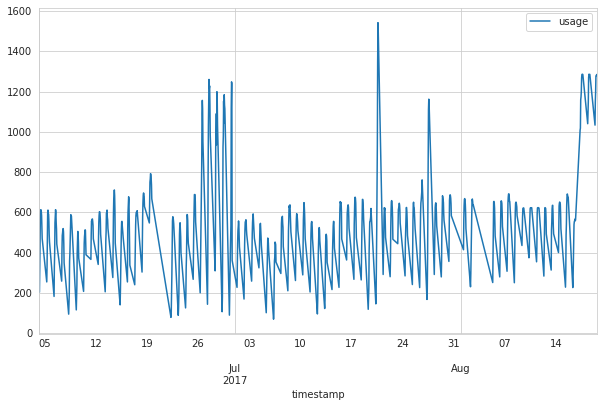

In [143]:
df0.plot()

The more length the more training time

In [144]:
length = 24       
batch_size = 50 
generator = TimeseriesGenerator(data = train_scaled, targets = train_scaled, length = length, batch_size = batch_size)

In [145]:

X, y = generator[0]

In [146]:
len(generator)

30

In [147]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.09097081 0.1778683  0.28173795 ... 0.15173116 0.14392396 0.13611677]
Predict this y: 
[[0.12559403]
 [0.17990496]
 [0.28309572]
 [0.35641548]
 [0.36795655]
 [0.35641548]
 [0.35437882]
 [0.3299389 ]
 [0.28581127]
 [0.26069246]
 [0.24842725]
 [0.23616203]
 [0.22389681]
 [0.21163159]
 [0.19936637]
 [0.18710115]
 [0.17483594]
 [0.16257072]
 [0.1503055 ]
 [0.13804028]
 [0.12577506]
 [0.11350984]
 [0.10124463]
 [0.08897941]
 [0.07671419]
 [0.17854718]
 [0.22267481]
 [0.32518669]
 [0.34487441]
 [0.36931432]
 [0.3604888 ]
 [0.32586558]
 [0.30414121]
 [0.25322471]
 [0.24541752]
 [0.23761032]
 [0.22980312]
 [0.22199593]
 [0.21418873]
 [0.20638153]
 [0.19857434]
 [0.19076714]
 [0.18295995]
 [0.17515275]
 [0.16734555]
 [0.15953836]
 [0.15173116]
 [0.14392396]
 [0.13611677]
 [0.12830957]]


# Modelling with Simple RNN

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

In [149]:

n_features = 1

In [150]:

model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(units = 100, activation = "tanh", input_shape=(length, n_features))) # units are number of neuron 


model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mse')

In [151]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.fit(x = generator, epochs = 50)

Epoch 1/50
30/30 [==============================] - 2s 13ms/step - loss: 0.0219
Epoch 2/50
30/30 [==============================] - 1s 16ms/step - loss: 0.0071
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0062
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0023
Epoch 11/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 12/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 13/50
30/30 [=====================

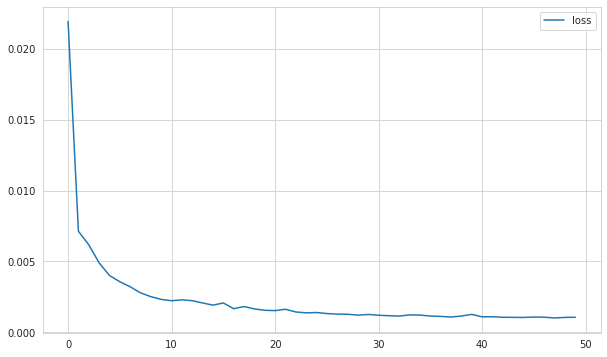

In [153]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [154]:
generator[0][0].shape

(50, 24, 1)

In [155]:
first_eval_batch = train_scaled[-length:]

In [156]:
first_eval_batch.shape

(24, 1)

In [157]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))


In [158]:
first_eval_batch.shape

(1, 24, 1)

In [159]:
model.predict(first_eval_batch)

array([[0.16936275]], dtype=float32)

In [160]:
test_scaled[0]

array([0.15631365])

In [161]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [162]:
current_batch.shape

(1, 24, 1)

In [163]:
current_batch

array([[[0.25458248],
        [0.25048795],
        [0.24639341],
        [0.24229888],
        [0.23820434],
        [0.23410981],
        [0.23001527],
        [0.22592074],
        [0.22182621],
        [0.21773167],
        [0.21363714],
        [0.2095426 ],
        [0.20544807],
        [0.20135353],
        [0.197259  ],
        [0.19316446],
        [0.18906993],
        [0.18497539],
        [0.18088086],
        [0.17678632],
        [0.17269179],
        [0.16859725],
        [0.16450272],
        [0.16040818]]])

In [164]:
np.append(current_batch[:,1:,:], [[[0.00775101]]], axis = 1)

array([[[0.25048795],
        [0.24639341],
        [0.24229888],
        [0.23820434],
        [0.23410981],
        [0.23001527],
        [0.22592074],
        [0.22182621],
        [0.21773167],
        [0.21363714],
        [0.2095426 ],
        [0.20544807],
        [0.20135353],
        [0.197259  ],
        [0.19316446],
        [0.18906993],
        [0.18497539],
        [0.18088086],
        [0.17678632],
        [0.17269179],
        [0.16859725],
        [0.16450272],
        [0.16040818],
        [0.00775101]]])

## Final For Loop to predict step by step 

In [165]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
   
    current_pred = model.predict(current_batch)
    
    
    predictions_scaled.append(current_pred[0]) 
    
    
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [166]:
predictions_scaled

[array([0.16936275], dtype=float32),
 array([0.18115078], dtype=float32),
 array([0.19535655], dtype=float32),
 array([0.20710665], dtype=float32),
 array([0.2178967], dtype=float32),
 array([0.22754344], dtype=float32),
 array([0.23475228], dtype=float32),
 array([0.23901021], dtype=float32),
 array([0.24132834], dtype=float32),
 array([0.24288934], dtype=float32),
 array([0.2437273], dtype=float32),
 array([0.24376933], dtype=float32),
 array([0.24316058], dtype=float32),
 array([0.24224056], dtype=float32),
 array([0.24076271], dtype=float32),
 array([0.23906246], dtype=float32),
 array([0.23783085], dtype=float32),
 array([0.23566546], dtype=float32),
 array([0.23216885], dtype=float32),
 array([0.22802067], dtype=float32),
 array([0.22408955], dtype=float32),
 array([0.2202506], dtype=float32),
 array([0.21761668], dtype=float32),
 array([0.21903604], dtype=float32),
 array([0.22412622], dtype=float32),
 array([0.23228292], dtype=float32),
 array([0.24105455], dtype=float32),
 arr

In [167]:
test_scaled

array([[0.15631365],
       [0.15221911],
       [0.14812458],
       [0.14403004],
       [0.13993551],
       [0.13584097],
       [0.13174644],
       [0.1276519 ],
       [0.12355737],
       [0.21928038],
       [0.30346232],
       [0.3957909 ],
       [0.39714868],
       [0.39307536],
       [0.37474542],
       [0.33197556],
       [0.28038018],
       [0.27119258],
       [0.26200498],
       [0.25281738],
       [0.24362978],
       [0.23444218],
       [0.22525458],
       [0.21606698],
       [0.20687938],
       [0.19769179],
       [0.18850419],
       [0.17931659],
       [0.17012899],
       [0.16094139],
       [0.15175379],
       [0.14256619],
       [0.21792261],
       [0.2640869 ],
       [0.33876443],
       [0.3957909 ],
       [0.39918534],
       [0.39714868],
       [0.39035981],
       [0.35845214],
       [0.31228785],
       [0.30224033],
       [0.2921928 ],
       [0.28214528],
       [0.27209776],
       [0.26205024],
       [0.25200272],
       [0.241

## Inverse Transformation and Comparing

In [168]:
predictions = scaler.inverse_transform(predictions_scaled)

In [169]:
predictions

array([[319.4713361 ],
       [336.83509766],
       [357.76019496],
       [375.06809527],
       [390.96183896],
       [405.17149219],
       [415.79011212],
       [422.06204641],
       [425.47665034],
       [427.77600473],
       [429.01030788],
       [429.07222717],
       [428.1755279 ],
       [426.82034935],
       [424.64347267],
       [422.13900104],
       [420.32483837],
       [417.13521589],
       [411.98472089],
       [405.87444401],
       [400.08390419],
       [394.42914343],
       [390.54936564],
       [392.64009088],
       [400.13792169],
       [412.15274362],
       [425.07335187],
       [438.4583877 ],
       [451.53992903],
       [463.10502949],
       [471.82241344],
       [477.93119776],
       [482.44676217],
       [485.61599365],
       [487.52269503],
       [488.61138579],
       [489.29089564],
       [489.39506754],
       [489.16424754],
       [488.85335609],
       [487.68086249],
       [484.9887673 ],
       [480.82096934],
       [476

In [170]:
test

,usage
timestamp,
2017-08-05 00:00:00,300.250
2017-08-05 01:00:00,294.219
2017-08-05 02:00:00,288.188
2017-08-05 03:00:00,282.156
2017-08-05 04:00:00,276.125
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


In [171]:
test['RNN_Predictions'] = predictions

In [172]:
test

,usage,RNN_Predictions
timestamp,,
2017-08-05 00:00:00,300.250,319.471
2017-08-05 01:00:00,294.219,336.835
2017-08-05 02:00:00,288.188,357.760
2017-08-05 03:00:00,282.156,375.068
2017-08-05 04:00:00,276.125,390.962
...,...,...
2017-08-19 12:00:00,1281.000,676.593
2017-08-19 13:00:00,1283.000,676.617
2017-08-19 14:00:00,1285.000,676.636


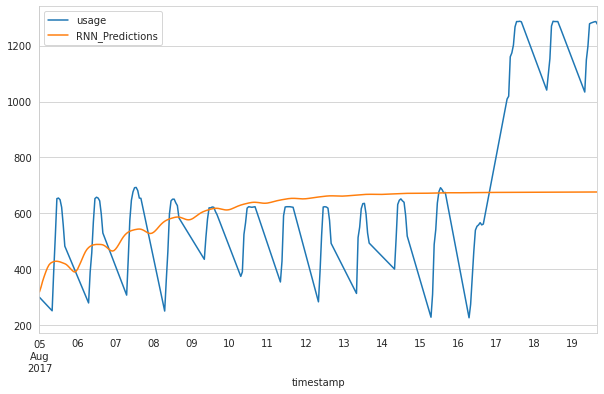

In [173]:
test.plot()

# Modelling with LSTM

In [174]:

model = Sequential()

# LSTM layer
model.add(LSTM(units = 100, activation = "tanh", input_shape = (length, n_features)))


model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mse')

In [175]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Early Stopping and Validation Generator

In [176]:
from tensorflow.keras.callbacks import EarlyStopping

In [177]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

In [178]:
length = 24 
            
batch_size =50

generator = TimeseriesGenerator(data = train_scaled, targets = train_scaled, length = length, batch_size = batch_size)

validation_generator = TimeseriesGenerator(data = test_scaled, targets = test_scaled, length = length, batch_size = batch_size)

In [179]:
len(validation_generator)

7

In [180]:
model.fit(x = generator,
          validation_data = validation_generator,
          epochs = 40,
          callbacks = [early_stop])

Epoch 1/40
30/30 [==============================] - 3s 45ms/step - loss: 0.0188 - val_loss: 0.0163
Epoch 2/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0113 - val_loss: 0.0201
Epoch 3/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0094 - val_loss: 0.0123
Epoch 4/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 5/40
30/30 [==============================] - 1s 28ms/step - loss: 0.0063 - val_loss: 0.0087
Epoch 6/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0057 - val_loss: 0.0119
Epoch 7/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 8/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 9/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 10/40
30/30 [==============================] - 1s 27ms/step - loss: 0.0037 - val_loss: 0.0078
Epoch 11/

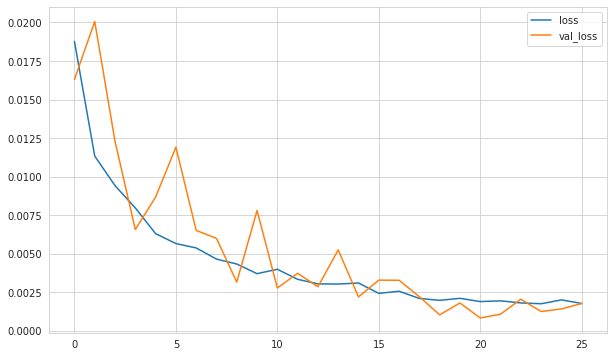

In [181]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [182]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

## Inverse Transformation and Comparing

In [183]:
predictions = scaler.inverse_transform(predictions_scaled)
test['LSTM Predictions'] = predictions
test

,usage,RNN_Predictions,LSTM Predictions
timestamp,,,
2017-08-05 00:00:00,300.250,319.471,336.286
2017-08-05 01:00:00,294.219,336.835,350.032
2017-08-05 02:00:00,288.188,357.760,367.855
2017-08-05 03:00:00,282.156,375.068,385.443
2017-08-05 04:00:00,276.125,390.962,400.600
...,...,...,...
2017-08-19 12:00:00,1281.000,676.593,711.702
2017-08-19 13:00:00,1283.000,676.617,711.989
2017-08-19 14:00:00,1285.000,676.636,712.274


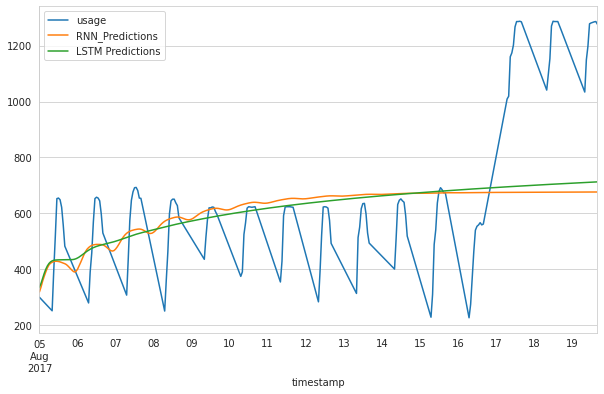

In [184]:
test.plot()

# Retrain and Forecasting

In [186]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df0)

In [189]:
length = 168 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 50)

In [190]:
model = Sequential()
model.add(LSTM(100, input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(x = generator, epochs = 30)

Epoch 1/30
34/34 [==============================] - 8s 139ms/step - loss: 0.0210
Epoch 2/30
34/34 [==============================] - 5s 139ms/step - loss: 0.0131
Epoch 3/30
34/34 [==============================] - 5s 136ms/step - loss: 0.0107
Epoch 4/30
34/34 [==============================] - 5s 138ms/step - loss: 0.0098
Epoch 5/30
34/34 [==============================] - 5s 137ms/step - loss: 0.0089
Epoch 6/30
34/34 [==============================] - 5s 138ms/step - loss: 0.0071
Epoch 7/30
34/34 [==============================] - 5s 158ms/step - loss: 0.0065
Epoch 8/30
34/34 [==============================] - 5s 137ms/step - loss: 0.0063
Epoch 9/30
34/34 [==============================] - 5s 138ms/step - loss: 0.0056
Epoch 10/30
34/34 [==============================] - 5s 140ms/step - loss: 0.0050
Epoch 11/30
34/34 [==============================] - 5s 140ms/step - loss: 0.0046
Epoch 12/30
34/34 [==============================] - 5s 138ms/step - loss: 0.0039
Epoch 13/30
34/34 [======

In [191]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [192]:
forecast = scaler.inverse_transform(forecast)

In [193]:
forecast

array([[ 1287.07364959],
       [ 1299.16347265],
       [ 1314.29425484],
       [ 1330.35516524],
       [ 1346.47762179],
       [ 1362.58128965],
       [ 1379.00998437],
       [ 1396.28469718],
       [ 1414.96311867],
       [ 1435.57879514],
       [ 1458.62102282],
       [ 1484.54213518],
       [ 1513.77304304],
       [ 1546.74650097],
       [ 1583.92019808],
       [ 1625.8070482 ],
       [ 1673.007236  ],
       [ 1726.2463212 ],
       [ 1786.41123557],
       [ 1854.59576213],
       [ 1932.14689231],
       [ 2020.71522176],
       [ 2122.31272125],
       [ 2239.37770689],
       [ 2374.83840561],
       [ 2532.17634511],
       [ 2715.46199965],
       [ 2929.35004902],
       [ 3178.97525048],
       [ 3469.70871258],
       [ 3806.69256759],
       [ 4194.07437611],
       [ 4633.88156128],
       [ 5124.51796198],
       [ 5659.08760023],
       [ 6224.12161541],
       [ 6799.6801095 ],
       [ 7361.69529057],
       [ 7886.38874769],
       [ 8355.13122606],


In [194]:
df0

,usage
timestamp,
2017-06-04 07:00:00,204.000
2017-06-04 08:00:00,332.000
2017-06-04 09:00:00,485.000
2017-06-04 10:00:00,583.000
2017-06-04 11:00:00,614.000
...,...
2017-08-19 12:00:00,1281.000
2017-08-19 13:00:00,1283.000
2017-08-19 14:00:00,1285.000


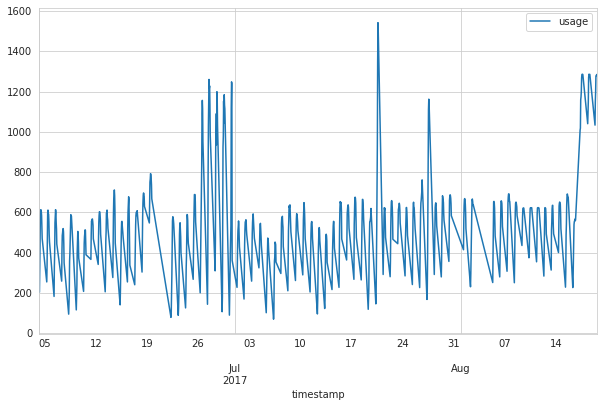

In [195]:
df0.plot()

In [196]:
forecast_len = len(forecast)
forecast_len

168

In [205]:
forecast_index = pd.date_range(start = '2017-08-05 07:00:00', periods = 168, freq = 'H')

In [206]:
len(forecast_index)

168

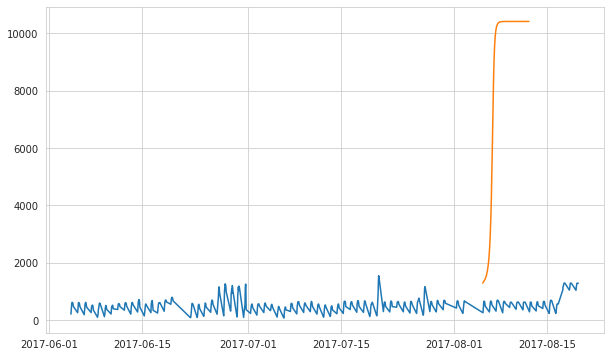

In [207]:
plt.plot(df0.index, df0['usage'])
plt.plot(forecast_index, forecast);